In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
#import cartopy.feature as cfeat
#import cartopy.io.img_tiles as cimgt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
#import AISMapPlot as aismap
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [2]:
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
test = pd.read_csv('rot_ham.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [3]:
ais_nan = test
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [24]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan
# Set invalid breadths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)
ais_test= ais_dropped


# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_test[ais_test['Longitude'] > 9.81].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_test[ais_test['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

# Add time for the entire trip to the data
ais_ham_zoned['TravelTime'] = ais_ham_zoned['EndTime'] - ais_ham_zoned['StartTime']
ais_ham_zoned['TravelTimeMins'] = ais_ham_zoned['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_ham_zoned['remainingTT'] = ais_ham_zoned['EndTime'] - ais_ham_zoned['time']
ais_ham_zoned['remainingMins'] = ais_ham_zoned['remainingTT'].transform(lambda x : x.total_seconds() / 60)


ais_test = ais_ham_zoned
ais_test = ais_test[['Latitude', 'Longitude', 'COG', 'SOG', 'remainingMins']]

C:\Users\eijoa\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
ais_test = ais_test.dropna()
ais_test

,Latitude,Longitude,COG,SOG,remainingMins
1,51.95,4.03,5.0,0.3,1374.0
2,51.95,4.03,8.0,0.4,1373.0
3,51.95,4.03,11.0,0.5,1372.0
4,51.95,4.03,12.0,0.5,1371.0
5,51.95,4.03,19.0,0.5,1370.0
6,51.95,4.03,13.0,0.5,1369.0
7,51.95,4.03,359.0,0.5,1368.0
8,51.95,4.03,354.0,0.5,1367.0
9,51.95,4.03,51.0,1.0,1366.0
10,51.95,4.03,61.0,1.3,1365.0


In [26]:
ais_learners = []
sectors = [0, 1, 2, 3, 4, 5]
sector_borders = [52.8, 4.8, 6.0, 7.2, 8.6, 9.81]
positions = pd.DataFrame([[52.8, np.nan], [np.nan, 4.8], [np.nan, 6.0], [np.nan, 7.2], [np.nan, 8.6], [np.nan, 9.81]],
                         columns = ['Latitude', 'Longitude'])
for s in sectors:
    ais_learners.append(pd.read_pickle('ROT-HAM_learners_01min_s%d.pkl' % (s)))

In [27]:
complete = ais_learners[0]
complete = complete.append(ais_learners[1])
complete = complete.append(ais_learners[2])
complete = complete.append(ais_learners[3])
complete = complete.append(ais_learners[4])
complete = complete.append(ais_learners[5])

In [28]:
X = complete[['Latitude', 'Longitude', 'COG', 'SOG']]
y = complete['remainingMins']

In [29]:

cv_splits = list(GroupKFold(n_splits = 10).split(X, y, groups = complete['TripID']))


In [30]:
cv_splits

[(array([     0,      1,      2, ..., 808814, 808815, 808816]),
  array([  2836,   2837,   2838, ..., 808507, 808508, 808509])),
 (array([     0,      1,      2, ..., 808814, 808815, 808816]),
  array([  1414,   1415,   1416, ..., 806118, 806119, 806120])),
 (array([     0,      1,      2, ..., 808814, 808815, 808816]),
  array([   990,    991,    992, ..., 805070, 805071, 805072])),
 (array([     0,      1,      2, ..., 808814, 808815, 808816]),
  array([  1229,   1230,   1231, ..., 803441, 803442, 803443])),
 (array([     0,      1,      2, ..., 808814, 808815, 808816]),
  array([ 12063,  12064,  12065, ..., 802600, 802601, 802602])),
 (array([     0,      1,      2, ..., 808814, 808815, 808816]),
  array([   235,    236,    237, ..., 806932, 806933, 806934])),
 (array([   235,    236,    237, ..., 808814, 808815, 808816]),
  array([     0,      1,      2, ..., 807745, 807746, 807747])),
 (array([     0,      1,      2, ..., 808814, 808815, 808816]),
  array([   684,    685,    686, 

In [31]:
# Create a train-test split
train_indices, test_indicies = cv_splits[0]
X_train, X_test = X.iloc[train_indices], X.iloc[test_indicies]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indicies]

In [32]:
X_train

,Latitude,Longitude,COG,SOG
834543,51.97,4.03,112.3,5.4
834550,51.97,4.03,112.4,5.2
834566,51.97,4.04,113.2,5.0
834343,51.96,4.04,112.8,4.8
834348,51.96,4.04,111.2,4.8
834587,51.96,4.04,110.3,5.2
834596,51.96,4.04,111.1,5.4
834370,51.96,4.05,110.3,5.6
834611,51.96,4.05,110.9,5.8
834408,51.96,4.05,110.5,6.0


In [33]:
# knn = KNeighborsRegressor()

# knn_params = dict(n_neighbors = range(5, 40), weights = [ 'distance'])
# knn_rand = RandomizedSearchCV(knn, knn_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 5)
# knn_rand.fit(X, y)

# pd.DataFrame(knn_rand.cv_results_).transpose()

In [34]:
# pd.DataFrame(knn_rand.cv_results_).transpose()

In [35]:
knn_best = KNeighborsRegressor(n_neighbors = 41, weights = 'distance')
knn_best.fit(X_train, y_train)

knn_predicts = knn_best.predict(ais_test[['Latitude', 'Longitude', 'COG', 'SOG']])

In [36]:
knn_predicts_diffs = knn_predicts - ais_test['remainingMins']

In [37]:
knn_predicts_frame = pd.DataFrame({'correct': ais_test['remainingMins'], 'knn_predicted': knn_predicts, 'diff': knn_predicts_diffs})
knn_predicts_frame['abs_error'] = knn_predicts_frame['diff'].transform(lambda x: abs(x))
knn_predicts_frame = knn_predicts_frame.sort_values('correct')
knn_predicts_frame['abs_error'].describe()

count    1347.000000
mean        5.265228
std        21.091128
min         0.000000
25%         0.000000
50%         0.000000
75%         0.500000
max       361.500000
Name: abs_error, dtype: float64

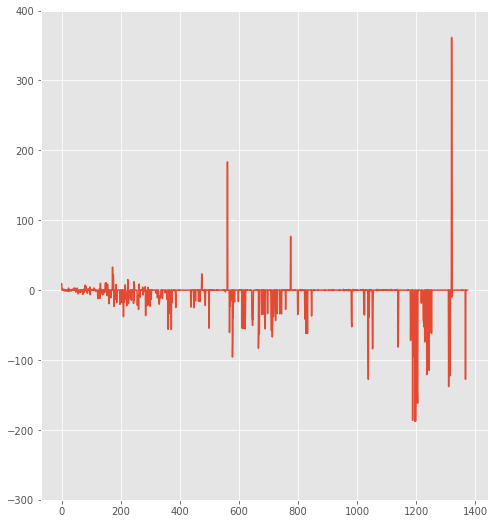

In [42]:
plt.figure(figsize = (8, 9))
axes = plt.gca()
axes.set_ylim([-300,400])
plt.plot(knn_predicts_frame['correct'], knn_predicts_frame['diff'])
plt.savefig('../Images/rot_ham_complete_knn_test.png', dpi = 300, bbox_inches = 'tight')

In [36]:
# rfo = RandomForestRegressor()
# rfo_params = dict(n_estimators = range(1, 10), max_depth = range(5,15))
# rfo_rand = RandomizedSearchCV(rfo, rfo_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
# rfo_rand.fit(X, y)

# pd.DataFrame(rfo_rand.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,6.717749,0.036779,-72.188064,-66.923802,10,7,"{'n_estimators': 7, 'max_depth': 10}",5,-63.289269,-68.085145,...,-74.107047,-66.440950,-74.586754,-66.274683,-79.909613,-66.338415,0.284074,0.004420,5.854208,0.769530
1,6.961156,0.043571,-72.008437,-62.718484,12,6,"{'n_estimators': 6, 'max_depth': 12}",2,-63.087245,-63.804828,...,-73.881314,-62.252067,-74.297549,-62.228958,-79.380798,-62.252308,0.448323,0.003955,5.959809,0.719812
2,2.462715,0.019688,-73.464321,-61.192232,13,2,"{'n_estimators': 2, 'max_depth': 13}",8,-64.602818,-62.365535,...,-75.719180,-60.766185,-75.270114,-60.582573,-81.931365,-60.913382,0.127158,0.002607,6.045221,0.695738
3,0.805985,0.013493,-75.404177,-73.372681,7,1,"{'n_estimators': 1, 'max_depth': 7}",9,-66.353507,-74.304491,...,-77.866840,-72.783875,-78.392806,-72.673209,-84.393163,-72.439592,0.028500,0.012971,6.327982,0.863538
4,8.797507,0.058742,-72.167592,-57.222719,14,7,"{'n_estimators': 7, 'max_depth': 14}",4,-62.826534,-58.281366,...,-74.303921,-56.811868,-74.190816,-56.555706,-79.344943,-56.714584,0.380499,0.007209,5.923299,0.672891
5,10.920737,0.071491,-71.972123,-57.080947,14,9,"{'n_estimators': 9, 'max_depth': 14}",1,-62.697296,-58.245695,...,-74.014047,-56.634458,-73.911651,-56.615363,-79.333226,-56.563124,0.199592,0.003415,5.909995,0.651357
6,4.149182,0.020788,-76.669642,-75.041277,6,6,"{'n_estimators': 6, 'max_depth': 6}",10,-67.911237,-76.059959,...,-79.195263,-74.172237,-80.242855,-74.610038,-85.803628,-74.063208,0.089782,0.002784,6.229046,0.967338
7,3.408138,0.018090,-73.369039,-70.522326,8,4,"{'n_estimators': 4, 'max_depth': 8}",7,-64.973216,-71.770224,...,-75.483265,-69.909064,-76.248967,-69.939054,-82.017271,-69.836494,0.128744,0.002021,6.060439,0.890765
8,8.009538,0.051390,-72.122640,-60.140537,13,7,"{'n_estimators': 7, 'max_depth': 13}",3,-62.972526,-61.387844,...,-73.855157,-59.637081,-74.222664,-59.583954,-79.738639,-59.705004,0.035156,0.002619,5.908898,0.745823
9,1.812212,0.013393,-73.100181,-69.312481,9,2,"{'n_estimators': 2, 'max_depth': 9}",6,-64.236323,-70.495895,...,-75.307215,-68.768859,-75.719951,-68.790089,-80.865841,-68.625086,0.048944,0.001114,5.873341,0.917070


In [43]:
rfr_best = RandomForestRegressor(max_depth = 10, n_estimators = 15)
rfr_best.fit(X_train, y_train)

rfr_predicts = rfr_best.predict(ais_test[['Latitude', 'Longitude', 'COG', 'SOG']])

In [44]:
rfr_predicts_diffs = rfr_predicts - ais_test['remainingMins']

In [45]:
rfr_predicts_frame = pd.DataFrame({'correct': ais_test['remainingMins'], 'rfr_predicted': rfr_predicts, 'diff': rfr_predicts_diffs})
rfr_predicts_frame['abs_error'] = rfr_predicts_frame['diff'].transform(lambda x: abs(x))
rfr_predicts_frame = rfr_predicts_frame.sort_values('correct')
rfr_predicts_frame['abs_error'].describe()

count    1347.000000
mean       40.734414
std        31.607971
min         0.009834
25%        12.619623
50%        36.060845
75%        64.406899
max       143.600791
Name: abs_error, dtype: float64

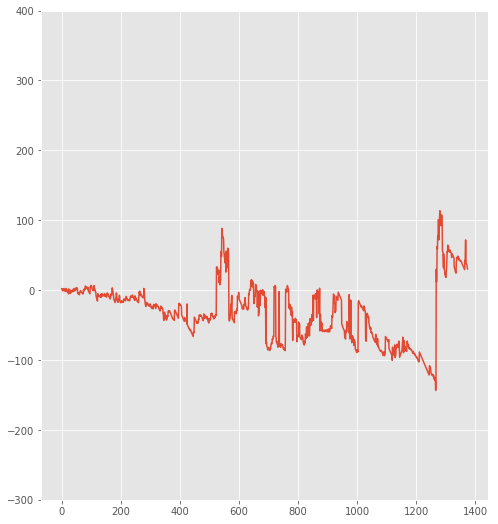

In [48]:
plt.figure(figsize = (8, 9))
axes = plt.gca()
axes.set_ylim([-300,400])
plt.plot(rfr_predicts_frame['correct'], rfr_predicts_frame['diff'])
plt.savefig('../Images/rot_ham_complete_rfr_test.png', dpi = 300, bbox_inches = 'tight')